# LFW

In [ ]:
#| default_exp lfw

In [ ]:
#| export
from abc import ABC, abstractmethod

from fastai.vision.all import *
from sklearn.model_selection import KFold
from fastdownload import FastDownload

import fast_datasets.patches
from fast_datasets.utils import return_list

In [ ]:
#| exporti
def _url(fname):
    return f'http://vis-www.cs.umass.edu/lfw/{fname}'

class LFW(ABC):
    TEST_ITEMS_FILE_NAME: str

    def __init__(self):
        self.root = untar_data(_url('lfw.tgz'))

    def test(self):
        items = self._parse_items(self.TEST_ITEMS_FILE_NAME)
        splits = KFold(n_splits=10, shuffle=False).split(range_of(items))
        return [self._load(items=items, splits=s) for s in splits]

    def _fetch_file(self, fname):
        return FastDownload().download(_url(fname))

    @abstractmethod
    def _parse_items(self, fname):
        pass

    @abstractmethod
    def _load(self, **kwargs):
        pass

    def _get_path(self, name, num) -> Path:
        return self.root / name / f'{name}_{num:04d}.jpg'


class LFWDevMixin(LFW):
    DEV_TRAIN_ITEMS_FILE_NAME: str
    DEV_TEST_ITEMS_FILE_NAME: str

    def dev(self):
        train_items = self._parse_items(self.DEV_TRAIN_ITEMS_FILE_NAME)
        valid_items = self._parse_items(self.DEV_TEST_ITEMS_FILE_NAME)
        items = valid_items+train_items

        return self._load(
            items=items,
            splits=IndexSplitter(range_of(valid_items))(items)
        )

In [ ]:
#| export
class LFWPeople(LFWDevMixin, LFW):
    """
    Individual facial images.
    Splits contain disjoint identities, since they're meant to for constructing pairs (using `Pairs`)
    """
    TEST_ITEMS_FILE_NAME = 'people.txt'
    DEV_TRAIN_ITEMS_FILE_NAME = 'peopleDevTrain.txt'
    DEV_TEST_ITEMS_FILE_NAME = 'peopleDevTest.txt'
    
    @return_list
    def _parse_items(self, fname):
        lines = [l.split() for l in self._fetch_file(fname).readlines()]
        for l in lines[1:]:
            if len(l) == 1:
                continue
            name, num_images = l
            for i in range(1, int(num_images)+1):
                yield self._get_path(name, i)

    def _load(self, **kwargs):
        return Datasets(
            tfms=[
                PILImage.create,
                [parent_label, lambda s: s.replace('_', ' '), Categorize()]
            ],
            train_setup=False,
            **kwargs
        )


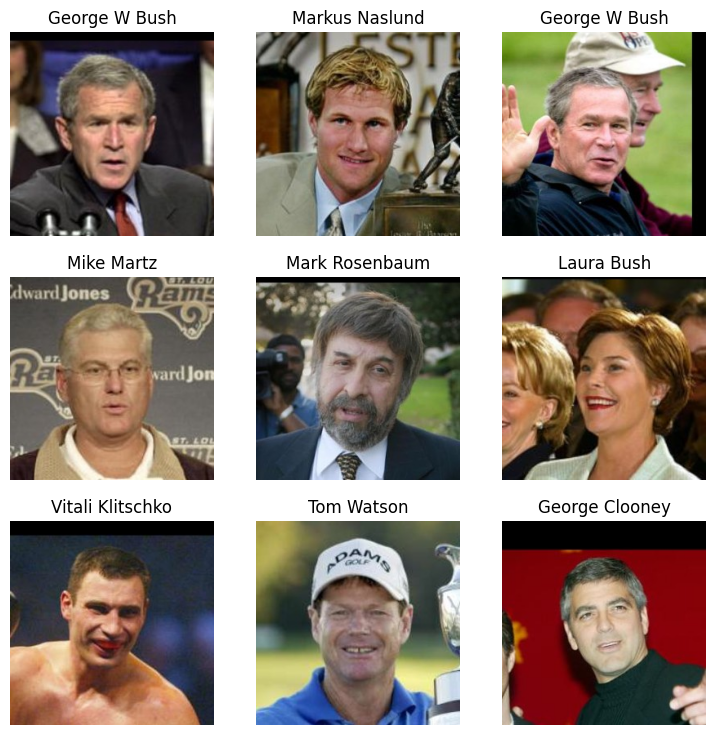

In [ ]:
LFWPeople().dev().dls().show_batch()

In [ ]:
#| export
from fast_datasets.pairs import *

In [ ]:
#| exporti
class LFWPairsMixin(LFW):
    """Fixed pairs of facial images"""
    TEST_ITEMS_FILE_NAME = 'pairs.txt'
    DEV_TRAIN_ITEMS_FILE_NAME = 'pairsDevTrain.txt'
    DEV_TEST_ITEMS_FILE_NAME = 'pairsDevTest.txt'

    @return_list
    def _parse_items(self, fname):
        lines = self._fetch_file(fname).readlines()
        for l in lines[1:]:
            l = l.split()
            if len(l) == 3:
                name, num1, num2 = l
                yield [self._get_path(name, int(num1)),
                       self._get_path(name, int(num2))]
            else:
                name1, num1, name2, num2 = l
                yield [self._get_path(name1, int(num1)),
                       self._get_path(name2, int(num2))]
    
    def _load(self, **kwargs):
        return Datasets(
            tfms=[
                ImagePair.create,
                [lambda pair: parent_label(pair[0])==parent_label(pair[1]), Sameness()]
            ],
            train_setup=False,
            **kwargs
        )

In [ ]:
#| export
class LFWPairs(LFWDevMixin, LFWPairsMixin, LFW):
    pass

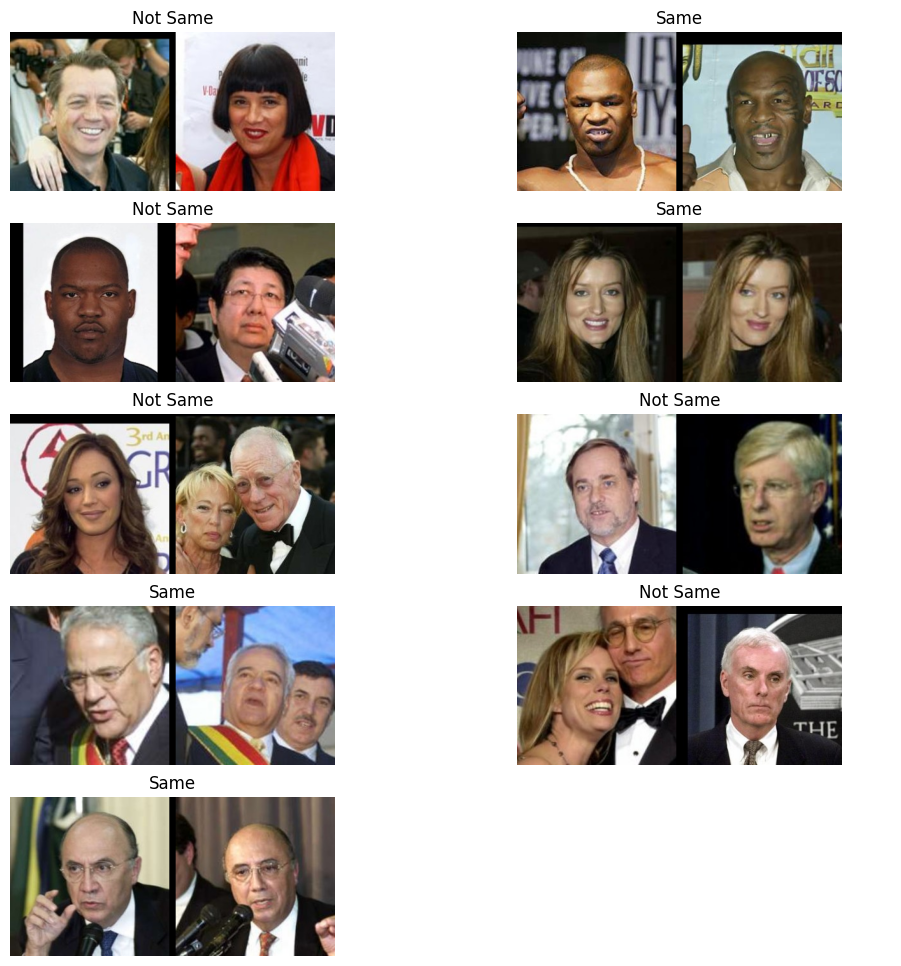

In [ ]:
LFWPairs().dev().dls().show_batch()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()